In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import scipy
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import seaborn as sns

To do list
1. exclude low activity for outlier detection
2. add offset or use peason corr for diff_log entropy data

In [377]:
wt_data = pd.read_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/wt_data.csv')
# # select features
# # basic_info = ['DIV', 'Well', 'Chip_ID', 'NeuronType', 'Trial']
# basic_info = ['Trial']
# # basic_features = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area',
# #             'mean_Burst_Peak', 'Number_Bursts', 'mean_BurstDuration']
# basic_features = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area',
#             'mean_Burst_Peak', 'Number_Bursts', 'mean_Spike_per_Burst']

# advanced_features = ['Mean_FiringRate',	'Mean_SpikeAmplitude',	'Active_area', 'mean_IBI', 'Number_Bursts', 'mean_Spike_per_Burst', 'mean_BurstDuration','mean_Burst_Peak',
#                      'mean_Burst_Peak_Abs','MeanNetworkISI','MeanWithinBurstISI', 'MeanOutsideBurstISI', 'Fanofactor', 'Burst_Peak_Abs']

In [378]:
# # dynamic select divs
# # Load the dataset
# wt_data = pd.read_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/wt_data.csv')

# # Filter DIVs between specified limits
# select_div_data = wt_data[(wt_data['DIV'] >= 14) & (wt_data['DIV'] <= 28)]

# # Identify trials
# trials = select_div_data['Trial'].unique()

# count = np.zeros(len(trials))
# # Calculate the number of unique DIVs in each trial
# for i, trial in enumerate(trials):
#     count[i] = select_div_data[select_div_data['Trial'] == trial]['DIV'].nunique()

# # Find the minimum number (integer) of DIVs present across trials (int)
# min_divs_count = int(count.min())
# min_divs_count

In [379]:
# # Center DIV to focus on (it could be set dynamically as well)
# center_div = 21

# # Correct the use of the DataFrame to avoid SettingWithCopyWarning
# results = {}
# for trial in select_div_data['Trial'].unique():
#     trial_data = select_div_data[select_div_data['Trial'] == trial].copy()  # Ensure working on a copy
#     trial_data['Difference'] = (trial_data['DIV'] - center_div).abs()
#     trial_data_sorted = trial_data.sort_values(by='Difference')
    
#     # Get the closest DIVs based on the sorted data
#     closest_div_index = trial_data_sorted.index[0]  # Getting the index of the closest div
#     closest_div = trial_data_sorted.loc[closest_div_index, 'DIV']

#     # Select a range of DIVs around the closest DIV
#     possible_divs = trial_data_sorted['DIV'].values
#     div_range = sorted(np.unique(possible_divs))  # Unique and sorted DIVs available in this trial
    
#     # Determine closest possible range around the chosen center
#     center_index = list(div_range).index(closest_div)
#     low = max(0, center_index - min_divs_count // 2)
#     high = min(len(div_range), low + min_divs_count)
    
#     # Adjust if not enough DIVs to the right
#     if high - low < min_divs_count:
#         low = max(0, high - min_divs_count)
    
#     # Final selection of DIVs
#     selected_divs = div_range[low:high]
#     results[trial] = f"Selected DIVs in trial {trial}: {', '.join(map(str, selected_divs))} (Count: {len(selected_divs)})"

# # Display the results
# for trial, result in results.items():
#     print(result)

In [380]:
# dynamic select divs function
def select_divs_around_center(data, lower_limit, upper_limit, center_div):

    # Filter DIVs between specified limits
    select_div_data = data[(data['DIV'] >= lower_limit) & (data['DIV'] <= upper_limit)]

    # Calculate the number of unique DIVs in each trial
    count_divs = select_div_data.groupby('Trial')['DIV'].nunique()

    # Find the minimum number of DIVs present across trials
    min_divs_count = int(count_divs.min())

    # Initialize results dictionary and an empty DataFrame for results
    results = {}
    filtered_dataset = pd.DataFrame()

    # Process each trial to fit within the centered range around the specified center DIV
    for trial in select_div_data['Trial'].unique():
        trial_data = select_div_data[select_div_data['Trial'] == trial].copy()  # Ensure working on a copy
        trial_data['Difference'] = (trial_data['DIV'] - center_div).abs()
        trial_data_sorted = trial_data.sort_values(by='Difference')
        
        # Get the closest DIVs based on the sorted data
        closest_div_index = trial_data_sorted.index[0]  # Getting the index of the closest div
        closest_div = trial_data_sorted.loc[closest_div_index, 'DIV']

        # Select a range of DIVs around the closest DIV
        possible_divs = trial_data_sorted['DIV'].values
        div_range = sorted(np.unique(possible_divs))  # Unique and sorted DIVs available in this trial
        
        # Determine closest possible range around the chosen center
        center_index = list(div_range).index(closest_div)
        low = max(0, center_index - min_divs_count // 2)
        high = min(len(div_range), low + min_divs_count)
        
        # Adjust if not enough DIVs to the right
        if high - low < min_divs_count:
            low = max(0, high - min_divs_count)
        
        # Final selection of DIVs
        selected_divs = div_range[low:high]
        results[trial] = f"Selected DIVs in trial {trial}: {', '.join(map(str, selected_divs))} (Count: {len(selected_divs)})"
        
        # Append the filtered data for these DIVs back into a DataFrame
        trial_filtered_data = trial_data[trial_data['DIV'].isin(selected_divs)]
        filtered_dataset = pd.concat([filtered_dataset, trial_filtered_data], ignore_index=True)

    # Print results and return the filtered dataset
    for trial, result in results.items():
        print(trial, result)
    
    return filtered_dataset

In [381]:
lower_limit = 14
upper_limit = 28
center_div = 21

select_div_data = select_divs_around_center(wt_data, lower_limit, upper_limit, center_div)

CDKL5-E6D_T1_C1_05152024 Selected DIVs in trial CDKL5-E6D_T1_C1_05152024: 16, 20, 23, 27 (Count: 4)
SYNGAP1_T1_C1_03212024 Selected DIVs in trial SYNGAP1_T1_C1_03212024: 15, 19, 22, 26 (Count: 4)
ADNP_T2_10262023 Selected DIVs in trial ADNP_T2_10262023: 14, 18, 21, 25 (Count: 4)
KCNT1_T3_C1_03122024 Selected DIVs in trial KCNT1_T3_C1_03122024: 14, 16, 21, 24 (Count: 4)
SPTAN1_T1_07192023 Selected DIVs in trial SPTAN1_T1_07192023: 16, 20, 23, 27 (Count: 4)
KCNT1_T1_08082023 Selected DIVs in trial KCNT1_T1_08082023: 14, 17, 21, 24 (Count: 4)
ADNP_T3_11072023 Selected DIVs in trial ADNP_T3_11072023: 14, 21, 24, 28 (Count: 4)
SHANK3_T1_11222023 Selected DIVs in trial SHANK3_T1_11222023: 16, 20, 23, 27 (Count: 4)
ADNP_T4_C1_06282024 Selected DIVs in trial ADNP_T4_C1_06282024: 14, 18, 21, 25 (Count: 4)
CHD8_T2_C1_08252023 Selected DIVs in trial CHD8_T2_C1_08252023: 18, 21, 25, 28 (Count: 4)


In [382]:
# # check dataset for each trial
# for trial in trials:
#     print(f"Trial: {trial}")
#     print(select_div_data[select_div_data['Trial'] == trial].to_string())

In [383]:
# select features
basic_info = ['Trial','DIV']
basic_features = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area',
                  'mean_Burst_Peak', 'Number_Bursts', 'mean_Spike_per_Burst']
basic_data = select_div_data[basic_info + basic_features]

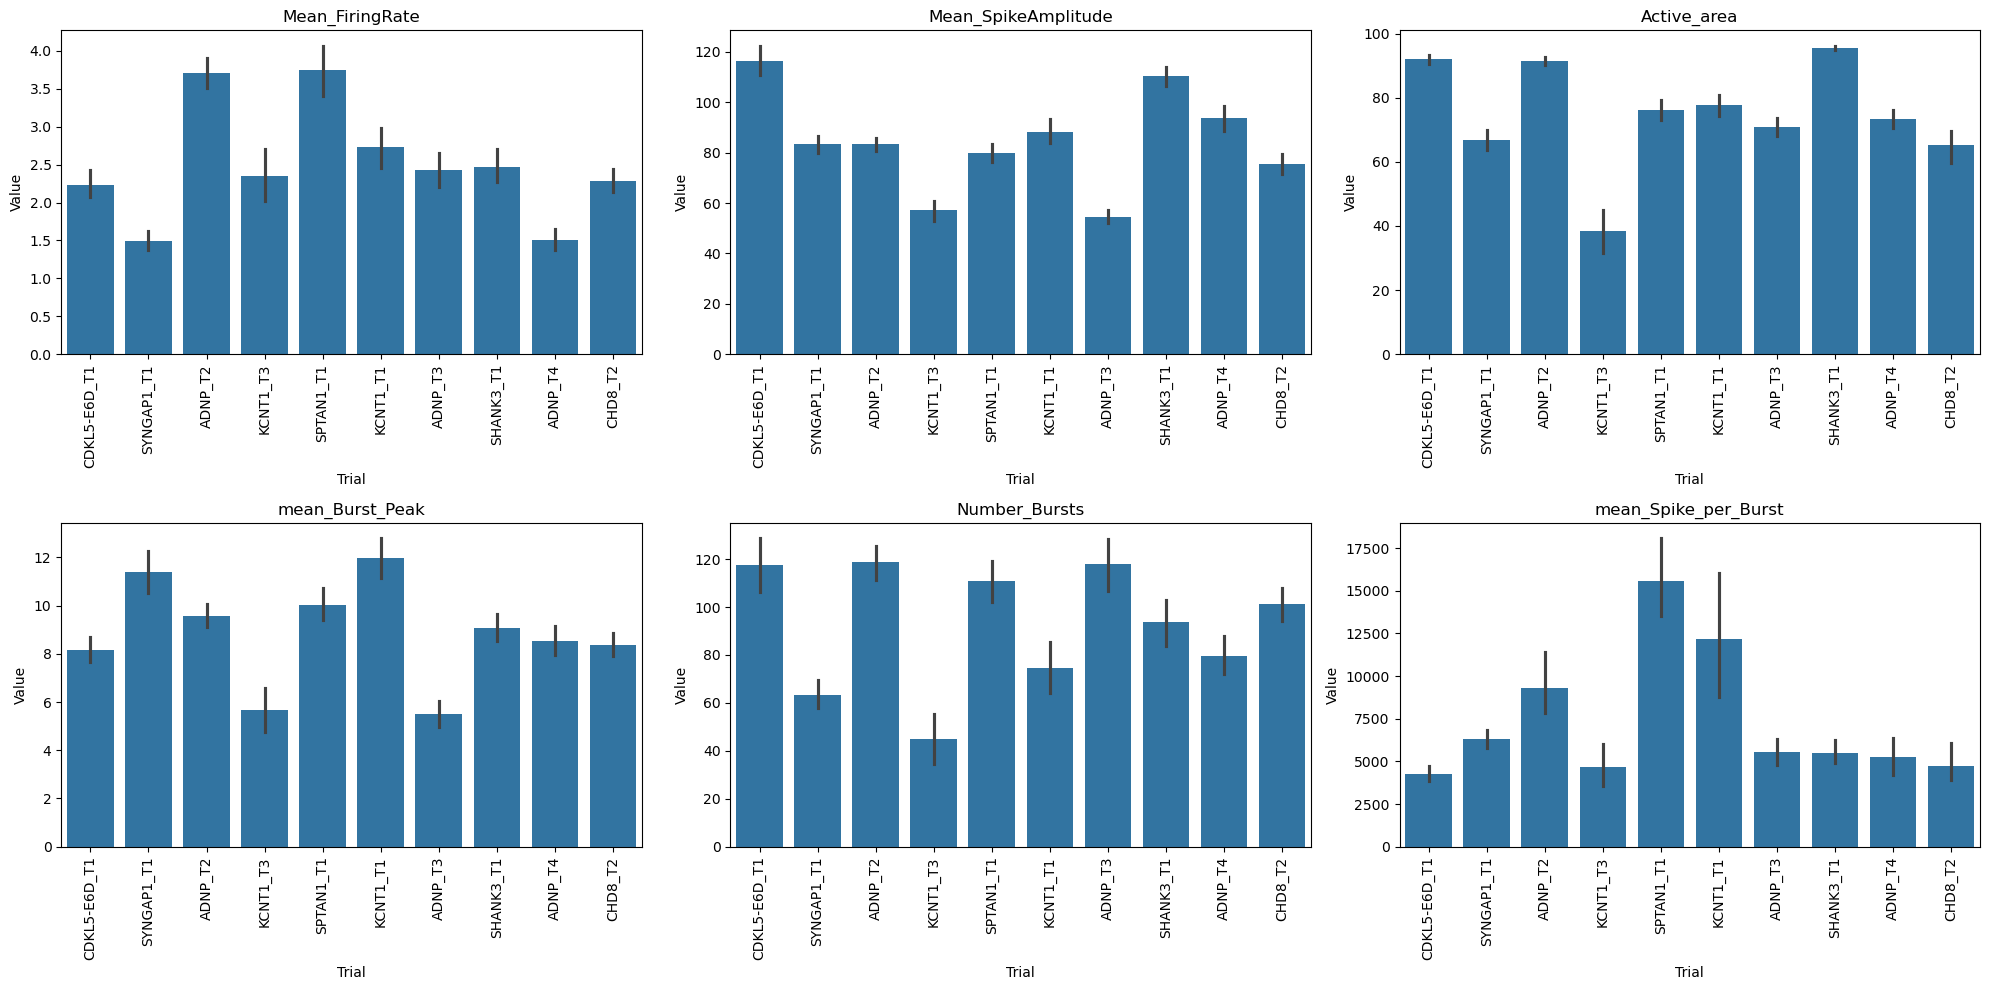

In [384]:
# bar plots for basic features in all trials (in 6 plots)

# Split 'Trial' names and keep only the parts you want
modify_data = basic_data.copy()
modify_data['Trial'] = basic_data['Trial'].apply(lambda x: '_'.join(x.split('_')[:2]))

# Now plot using Seaborn as before
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for ax, feature in zip(axes.flatten(), basic_features):
    sns.barplot(x='Trial', y=feature, data=modify_data, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('Trial')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

In [385]:
# average numbers in same div for each trial
combined_data = basic_data.groupby(['Trial', 'DIV']).mean().reset_index()

In [386]:
combined_data

,Trial,DIV,Mean_FiringRate,Mean_SpikeAmplitude,Active_area,mean_Burst_Peak,Number_Bursts,mean_Spike_per_Burst
0,ADNP_T2_10262023,14,3.282128,73.811046,87.848824,8.009766,99.882353,10298.374574
1,ADNP_T2_10262023,18,4.036184,82.979526,92.741176,10.508045,124.588235,11631.338770
2,ADNP_T2_10262023,21,4.090200,89.056548,94.100588,10.138665,128.529412,8005.942115
3,ADNP_T2_10262023,25,3.440013,87.441833,91.529412,9.630983,121.529412,7198.429634
4,ADNP_T3_11072023,14,2.319795,49.736041,66.515000,4.810329,103.000000,5489.571570
5,ADNP_T3_11072023,21,2.514856,55.512441,73.225000,5.426937,115.500000,4853.371331
6,ADNP_T3_11072023,24,2.313612,54.545208,70.320000,5.452262,124.000000,6457.533058
7,ADNP_T3_11072023,28,2.588263,58.168004,73.990000,6.393037,129.500000,5417.408806
8,ADNP_T4_C1_06282024,14,1.886431,87.203227,75.646465,8.694245,77.833333,8067.230469
9,ADNP_T4_C1_06282024,18,1.519728,99.941506,77.643939,8.853932,81.000000,5099.288149


In [387]:
unique_trials = combined_data['Trial'].unique()
feature_cols = basic_features

In [388]:
# # 2d matrix (no div info)
# entropy_matrix = np.zeros((len(unique_trials), len(feature_cols)))
# # transfrom one trial data to array
# for trial in unique_trials:
#     trial_data = combined_data[combined_data['Trial'] == trial]
#     trial_arr = trial_data[feature_cols].values
#     # take the mean of each feature
#     mean_data = np.mean(trial_arr, axis=0)
#     print(mean_data)
#     # store in matrix
#     index = np.where(unique_trials == trial)
#     entropy_matrix[index] = mean_data

In [389]:
entropy_trials = np.array(sorted(combined_data['Trial'].unique()))

**Mahalanobis distance matrix**

In [390]:
# config dist_matrix matrix, with div info

# Count the number of DIVs in the first trial
count_divs = combined_data.groupby('Trial')['DIV'].count().iloc[0]

num_trials = len(unique_trials)
num_features = len(feature_cols)
num_divs = count_divs
columns_per_trial = num_divs * num_features

# Initialize the dist_matrix matrix
dist_matrix = np.zeros((num_trials, columns_per_trial))


# Populate the matrix
for idx, trial in enumerate(entropy_trials):
    # Filter data for the current trial
    trial_data = combined_data[combined_data['Trial'] == trial]
    trial_data = trial_data.sort_values('DIV')  # Ensure the data is in DIV order
    
    # Flatten the trial data across DIVs for each feature
    trial_features = []
    for feature in feature_cols:
        trial_features.extend(trial_data[feature].tolist())  # Append feature data in DIV order
    
    # Store in the matrix
    dist_matrix[idx, :] = trial_features

In [391]:
# reshape the matrix to reduce dimension, avoid sigularity of covariance matrix
reshaped_matrix = dist_matrix.reshape(num_trials, num_features, num_divs)

# Calculate the average across DIVs for each feature in each trial
dist_matrix = reshaped_matrix.mean(axis=2)
dist_matrix

array([[3.71213135e+00, 8.33222381e+01, 9.15550000e+01, 9.57186466e+00,
        1.18632353e+02, 9.28352127e+03],
       [2.43413153e+00, 5.44904233e+01, 7.10125000e+01, 5.52064135e+00,
        1.18000000e+02, 5.55447119e+03],
       [1.50507969e+00, 9.36844178e+01, 7.33705808e+01, 8.52582066e+00,
        7.97083333e+01, 5.23724541e+03],
       [2.22660834e+00, 1.16522968e+02, 9.19727961e+01, 8.17600365e+00,
        1.17431818e+02, 4.23277348e+03],
       [2.28853734e+00, 7.55495735e+01, 6.52142500e+01, 8.36076362e+00,
        1.01125000e+02, 4.71904143e+03],
       [2.73099614e+00, 8.82424184e+01, 7.76590909e+01, 1.19634927e+01,
        7.46750000e+01, 1.21933704e+04],
       [2.44262781e+00, 5.49684938e+01, 3.47376894e+01, 5.76141263e+00,
        3.87291667e+01, 5.33663685e+03],
       [2.46564384e+00, 1.10260723e+02, 9.54877778e+01, 9.06802012e+00,
        9.35833333e+01, 5.51107191e+03],
       [3.74280525e+00, 7.96646657e+01, 7.62368750e+01, 1.00393468e+01,
        1.10781250e+02, 

In [392]:
# apply mahalanobis distance for outlier detection, using dist_matrix

# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(dist_matrix, rowvar=False)

mean_distr = np.mean(dist_matrix, axis=0)

# # Regularization term
# regularization_term = 0.001  # Small positive value

# # Dimension of the matrix (number of features)
# d = cov_matrix.shape[0]

# # Add regularization
# regularized_cov_matrix = cov_matrix + np.eye(d) * regularization_term

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance for each observation
distances = []

for i in range(dist_matrix.shape[0]):
    x = dist_matrix[i]
    md = mahalanobis(x, mean_distr, inv_cov_matrix)
    distances.append(md)

# Set the significance level
alpha = 0.05
df = dist_matrix.shape[1] # Degrees of freedom
threshold = chi2.ppf((1 - alpha), df)

# Flag observations exceeding the threshold
outliers = np.array(distances) > np.sqrt(threshold)
outlier_trials = entropy_trials[outliers]
print("Outlier Trials based on Mahalanobis Distance:", outlier_trials)

Outlier Trials based on Mahalanobis Distance: []


In [393]:
# calc feature contributions towards outlier dispersions
def calculate_feature_contributions(data_matrix, mean_vector, inv_cov):
    n_samples = data_matrix.shape[0] # Number of rows
    n_features = data_matrix.shape[1] # Number of columns
    contributions = np.zeros((n_samples, n_features))
    
    for i in range(n_samples):
        diff = data_matrix[i] - mean_vector
        # Compute the product for each feature contribution
        for j in range(n_features):
            # contributions[i, j] = diff[j] * np.dot(inv_cov[j], diff)
            # contributions[i, j] = (diff[j] * np.dot(inv_cov[j], diff)) ** 2
            contributions[i, j] = abs(diff[j] * np.dot(inv_cov[j], diff))
    return contributions


# Calculate all contributions
all_contributions = calculate_feature_contributions(dist_matrix, mean_distr, inv_cov_matrix)
all_contributions

array([[5.50341104, 0.06712126, 1.86644687, 0.69686315, 0.85520077,
        1.7124247 ],
       [0.24141887, 5.46541084, 0.78463251, 3.46944381, 0.12552012,
        0.8401313 ],
       [3.99908085, 0.23493806, 0.0656358 , 0.3010441 , 0.20440494,
        1.53200549],
       [0.07489341, 6.32338484, 3.53510918, 0.1513676 , 2.27983502,
        0.19096515],
       [0.44325959, 0.46637802, 2.92308303, 0.79112656, 1.42135315,
        2.42455615],
       [0.17216593, 0.19952214, 0.3441959 , 0.61162744, 1.01812163,
        1.70835381],
       [0.16409622, 1.46845512, 3.12326814, 1.93622708, 4.14687282,
        0.36533746],
       [0.0360306 , 0.55266124, 5.38481922, 0.17402705, 0.24845779,
        0.17613186],
       [1.17837733, 0.459105  , 0.29697441, 0.62880748, 1.38599388,
        7.85196281],
       [1.32491232, 0.05526652, 0.04053874, 3.4273879 , 0.22740276,
        0.36725424]])

In [394]:
# use dist_matrix, map and generate dict
def map_and_rank_contributions(dist_matrix, all_contributions, outliers, basic_features):
    # Extract the contributions for outlier trials
    outlier_contributions = all_contributions[outliers, :]
    outlier_names = np.array(entropy_trials)[outliers]  # Assuming entropy_trials contains trial names

    # Instead of ranking, just pair features with their contributions directly
    contributions_by_outlier = {}
    for index, trial_name in enumerate(outlier_names):
        contributions = outlier_contributions[index, :]
        contributions_by_outlier[trial_name] = [(basic_features[i], contributions[i]) for i in range(len(basic_features))]
    
    return contributions_by_outlier

contributions_dict = map_and_rank_contributions(dist_matrix, all_contributions, np.array(outliers), basic_features)
contributions_dict

{}

/var/folders/hz/mtvvz9t52kxgqcx423vlrhx00000gn/T/ipykernel_7402/1986024077.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Trials', bbox_to_anchor=(1.05, 1), loc='upper left')


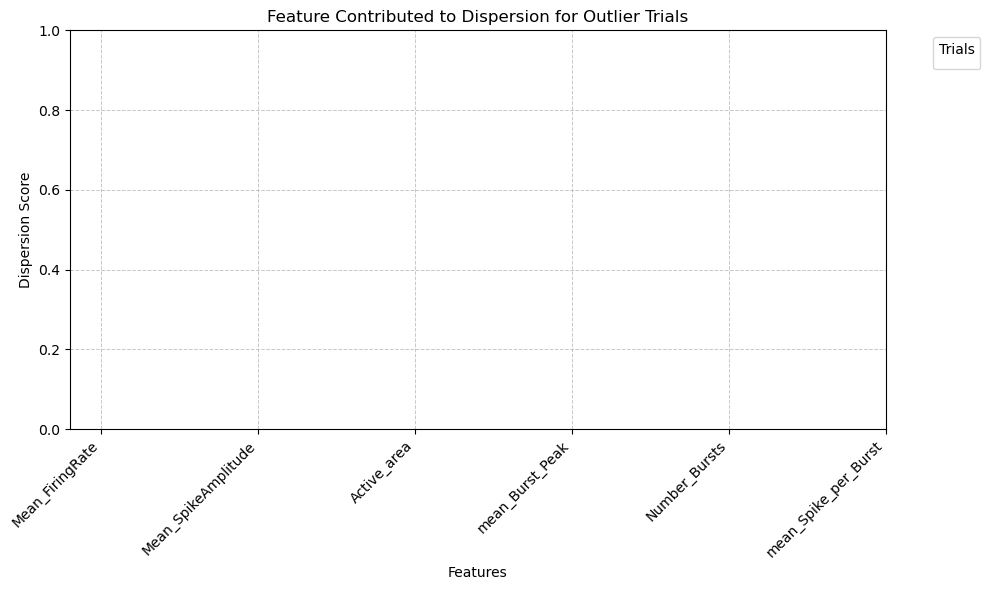

In [395]:
# Plotting the Contributions
trial_names = list(contributions_dict.keys())

# Prepare data for plotting
contributions_data = np.array([[contribution for _, contribution in contributions_dict[trial]] for trial in trial_names])

# Plotting parameters
num_features = len(basic_features)
num_trials = len(trial_names)
x = np.arange(num_features)  # X-axis positions for each feature
bar_width = 0.2  # Width of each bar

plt.figure(figsize=(10, 6))

# Plot each trial's contributions as bars
for i in range(num_trials):
    plt.bar(
        x + i * bar_width,  # Shift bars for each trial
        contributions_data[i],  # Contributions for the current trial
        width=bar_width, 
        label=trial_names[i], 
        align='center'
    )

# Configure x-axis labels and ticks
plt.xticks(x + bar_width, basic_features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Dispersion Score')
plt.title('Feature Contributed to Dispersion for Outlier Trials')

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(title='Trials', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Entropy**


In [396]:
# config entropy matrix, with div info

count_divs = combined_data.groupby('Trial')['DIV'].count().iloc[0]

num_trials = len(unique_trials)
num_features = len(feature_cols)
num_divs = count_divs
columns_per_trial = num_divs * num_features

# Initialize the entropy matrix
entropy_matrix = np.zeros((num_trials, columns_per_trial))


# Define your trials - assuming your trials are uniquely and sequentially numbered
entropy_trials = np.array(sorted(combined_data['Trial'].unique()))

# Populate the matrix
for idx, trial in enumerate(entropy_trials):
    # Filter data for the current trial
    trial_data = combined_data[combined_data['Trial'] == trial]
    trial_data = trial_data.sort_values('DIV')  # Ensure the data is in DIV order
    
    # Flatten the trial data across DIVs for each feature
    trial_features = []
    for feature in feature_cols:
        trial_features.extend(trial_data[feature].tolist())  # Append feature data in DIV order
    
    # Store in the matrix
    entropy_matrix[idx, :] = trial_features

# Print the matrix to see the result
print(entropy_matrix)

[[3.28212815e+00 4.03618434e+00 4.09020030e+00 3.44001260e+00
  7.38110463e+01 8.29795256e+01 8.90565478e+01 8.74418328e+01
  8.78488235e+01 9.27411765e+01 9.41005882e+01 9.15294118e+01
  8.00976586e+00 1.05080446e+01 1.01386649e+01 9.63098330e+00
  9.98823529e+01 1.24588235e+02 1.28529412e+02 1.21529412e+02
  1.02983746e+04 1.16313388e+04 8.00594211e+03 7.19842963e+03]
 [2.31979544e+00 2.51485583e+00 2.31361208e+00 2.58826278e+00
  4.97360409e+01 5.55124405e+01 5.45452080e+01 5.81680038e+01
  6.65150000e+01 7.32250000e+01 7.03200000e+01 7.39900000e+01
  4.81032940e+00 5.42693748e+00 5.45226155e+00 6.39303697e+00
  1.03000000e+02 1.15500000e+02 1.24000000e+02 1.29500000e+02
  5.48957157e+03 4.85337133e+03 6.45753306e+03 5.41740881e+03]
 [1.88643113e+00 1.51972768e+00 1.41487499e+00 1.19928496e+00
  8.72032271e+01 9.99415065e+01 9.07716974e+01 9.68212404e+01
  7.56464646e+01 7.76439394e+01 7.04772727e+01 6.97146465e+01
  8.69424515e+00 8.85393242e+00 8.62894597e+00 7.92615911e+00
  7.78

In [397]:
# normalize the matrix to make sure each row sums to 1
def normalize_arr(arr):
    return np.array([x/np.sum(arr) for x in arr])

# Normalize the matrix and get the central array as reference entropy array
def make_central_arr(arrs):
    central_arr = (arrs[0])
    for i in range(1, len(arrs)):
        central_arr = np.add(central_arr, arrs[i])
    return normalize_arr(central_arr)

central_arr = make_central_arr(entropy_matrix)

In [398]:
# log the matrix
log_central_arr = np.log(central_arr)

# get the diff of log_central_arr 
diff_log_central_arr = np.diff(log_central_arr)


<Axes: >

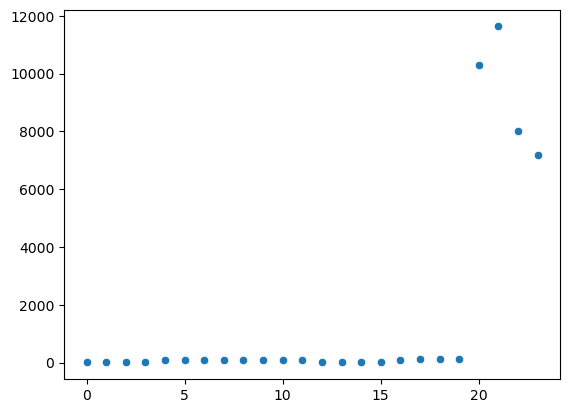

In [399]:
sns.scatterplot(entropy_matrix[0])

<Axes: >

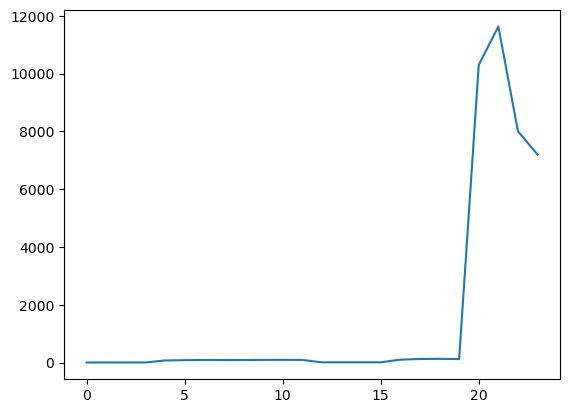

In [400]:
sns.lineplot(entropy_matrix[0])

<Axes: >

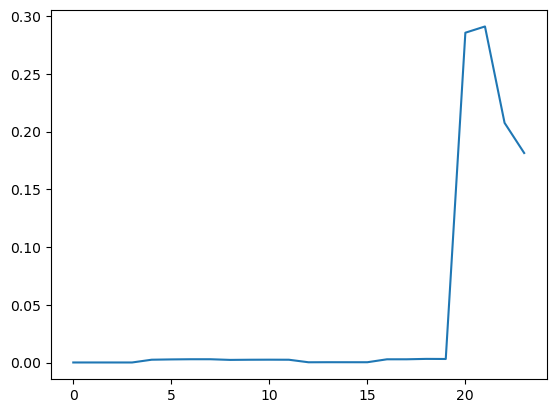

In [401]:
sns.lineplot(central_arr)

<Axes: >

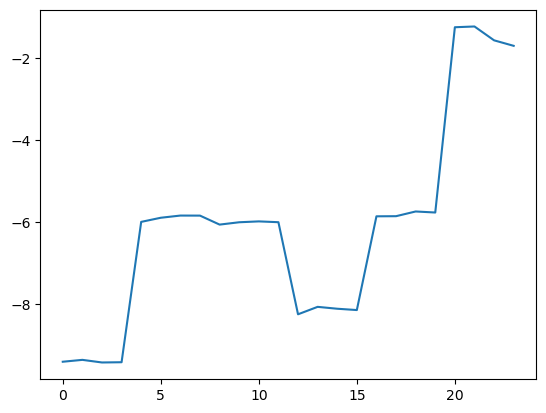

In [402]:
sns.lineplot(log_central_arr)


<Axes: >

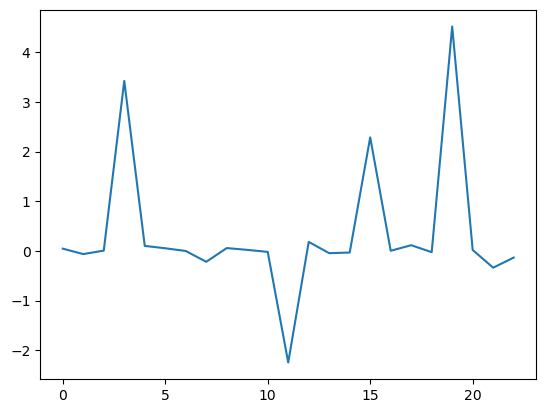

In [403]:
sns.lineplot(diff_log_central_arr)

In [404]:
# take log and diff for each row in entropy_matrix
log_entropy_matrix = np.log(entropy_matrix)
diff_log_entropy_matrix = np.diff(log_entropy_matrix)
diff_log_entropy_matrix

array([[ 2.06807738e-01,  1.32941669e-02, -1.73118807e-01,
         3.06603326e+00,  1.17085498e-01,  7.06776394e-02,
        -1.82977326e-02,  4.64361848e-03,  5.41951418e-02,
         1.45517332e-02, -2.77039371e-02, -2.43599883e+00,
         2.71479589e-01, -3.57847983e-02, -5.13709916e-02,
         2.33900769e+00,  2.21021159e-01,  3.11435814e-02,
        -5.60014579e-02,  4.43958505e+00,  1.21716999e-01,
        -3.73519043e-01, -1.06321135e-01],
       [ 8.07364724e-02, -8.34055071e-02,  1.12176938e-01,
         2.95574293e+00,  1.09877310e-01, -1.75772872e-02,
         6.43055784e-02,  1.34092045e-01,  9.61094066e-02,
        -4.04806393e-02,  5.08736956e-02, -2.73316438e+00,
         1.20609410e-01,  4.65551129e-03,  1.59178939e-01,
         2.77951956e+00,  1.14541542e-01,  7.10110356e-02,
         4.33993155e-02,  3.74692461e+00, -1.23176631e-01,
         2.85573782e-01, -1.75629744e-01],
       [-2.16155596e-01, -7.14899788e-02, -1.65315669e-01,
         4.28651583e+00,  1.3

In [405]:
# apply entropy based outlier detection
# below are helper functions
def entropy_func(x: float):
    return x * np.log2(x)
def weight_intensity(arr):
    S = scipy.stats.entropy(arr)
    # print(S)
    if S >= 3:
        return arr
    else:
        w = 0.25+S*0.25
        return np.power(arr, w)

def entropy_match(m: float,
                  n: float):
    return entropy_func(m+n) - entropy_func(m) - entropy_func(n)
def normalize_arr(arr: np.array):
    return arr/np.sum(arr)

In [406]:
def unweighted_entropy_score(arr1: np.array, arr2: np.array):
    if len(arr1) != len(arr2):
        raise ValueError('Length of two arrays should be the same')
        return
    arr1 = normalize_arr(arr1)
    arr2 = normalize_arr(arr2)
    sum = 0
    for i in range(len(arr1)):
        sum += entropy_match(arr1[i], arr2[i])
    return sum/2
def weigthed_entropy_score(arr1: np.array, arr2: np.array):
    if len(arr1) != len(arr2):
        raise ValueError('Length of two arrays should be the same')
        return
    arr1 = (normalize_arr(weight_intensity(arr1)))
    arr2 = (normalize_arr(weight_intensity(arr2)))
    sum = 0
    for i in range(len(arr1)):
        sum += entropy_match(arr1[i], arr2[i])
    return sum/2

In [407]:
# Main function to calculate entropy scores for all pairs of rows
def calculate_entropy_scores(entropy_matrix, weighted=False):
    n_rows = entropy_matrix.shape[0]
    scores = np.zeros((n_rows, n_rows))
    for i in range(n_rows):
        for j in range(i + 1, n_rows):
            score = calculate_entropy_score(entropy_matrix[i], entropy_matrix[j], weighted)
            scores[i, j] = score
            scores[j, i] = score  # Symmetric matrix
    return scores

def calculate_entropy_score(arr1, arr2, weighted):
    if len(arr1) != len(arr2):
        raise ValueError('Length of two arrays should be the same')

    arr1 = normalize_arr(arr1)
    arr2 = normalize_arr(arr2)

    if weighted:
        arr1 = weight_intensity(arr1)
        arr2 = weight_intensity(arr2)

    sum_value = 0
    for i in range(len(arr1)):
        sum_value += entropy_match(arr1[i], arr2[i])
    return sum_value

In [408]:
# # calculate the scores row by row (trial by trial)
# unweighted_scores = calculate_entropy_scores(entropy_matrix)
# weighted_scores = calculate_entropy_scores(entropy_matrix, weighted=True)

# print("Unweighted Entropy Scores:\n", unweighted_scores)
# print("Weighted Entropy Scores:\n", weighted_scores)

Unweighted Scores reflect the basic differences in distribution without any adjustments for the underlying entropy within each row. This can be useful for straightforward comparisons where each element is considered equally.

Weighted Scores adjust for the entropy of each row before comparison. The weighting increases the influence of rows with lower inherent entropy (less randomness or more predictability) and decreases the influence of those with higher entropy. This can be particularly insightful when you want to account for the inherent randomness or predictability of the data.

Rows that are intrinsically more predictable (lower entropy) will have their differences emphasized when compared to more chaotic (higher entropy) rows.

In [409]:
# # compare the scores row by row (trial by trial) and find the outlier
# nthreshold = 2 # number of standard deviation to determine the threshold

# entropy_trials = np.array(entropy_trials)
# # Assuming 'weighted_scores' is the weighted entropy scores matrix already loaded
# n_rows = weighted_scores.shape[0]
# average_scores = np.zeros(n_rows)
# max_scores = np.zeros(n_rows)

# # Compute the average and max entropy scores for each trial, ignoring self-comparisons (diagonal)
# for i in range(n_rows):
#     # Include only the upper triangle starting just above the diagonal
#     relevant_scores = weighted_scores[i, i+1:]
#     # Combine with the lower triangle if necessary
#     if i > 0:
#         relevant_scores = np.concatenate((weighted_scores[i, :i], relevant_scores))
#     average_scores[i] = np.mean(relevant_scores)
#     max_scores[i] = np.max(relevant_scores)

# # Determine thresholds to identify outliers
# mean_avg_score = np.mean(average_scores)
# std_avg_score = np.std(average_scores)
# threshold_up = mean_avg_score + nthreshold * std_avg_score 
# threshold_down = mean_avg_score - nthreshold * std_avg_score

# # Identify outlier trials based on average or maximum scores
# outlier_indices_up = np.where(average_scores > threshold_up)[0] 
# outlier_indices_down = np.where(average_scores < threshold_down)[0]
# outlier_trials = entropy_trials[np.union1d(outlier_indices_up, outlier_indices_down)]

# print("Outlier Trials based on Average Scores:", outlier_trials)

In [410]:
# # create a reference entropy array by normalize all rows in entropy matrix
# ref_entropy_array = np.mean(entropy_matrix, axis=0)
# ref_entropy_array

In [411]:
# # compare each trial with the reference entropy array, and calculate weighted and unweighted socres in two output arrays
# unweighted_scores = np.zeros(entropy_matrix.shape[0])
# weighted_scores = np.zeros(entropy_matrix.shape[0])

# for i in range(entropy_matrix.shape[0]):
#     trial_data = entropy_matrix[i]
#     unweighted_scores[i] = unweighted_entropy_score(ref_entropy_array, trial_data)
#     weighted_scores[i] = weigthed_entropy_score(ref_entropy_array, trial_data)

# # print the results
# print("Unweighted Scores:", unweighted_scores)
# print("Weighted Scores:", weighted_scores)

In [412]:
# # determine the outlier trials based on the scores
# nthreshold = 2 # number of standard deviation to determine the threshold

# mean_unweighted = np.mean(unweighted_scores)
# std_unweighted = np.std(unweighted_scores)
# threshold_unweighted_up = mean_unweighted + nthreshold * std_unweighted
# threshold_unweighted_down = mean_unweighted - nthreshold * std_unweighted

# mean_weighted = np.mean(weighted_scores)
# std_weighted = np.std(weighted_scores)
# threshold_weighted_up = mean_weighted + nthreshold * std_weighted
# threshold_weighted_down = mean_weighted - nthreshold * std_weighted

# outlier_indices_unweighted_up = np.where(unweighted_scores > threshold_unweighted_up)[0]
# outlier_indices_unweighted_down = np.where(unweighted_scores < threshold_unweighted_down)[0]
# outlier_trials_unweighted = entropy_trials[np.union1d(outlier_indices_unweighted_up, outlier_indices_unweighted_down)]

# outlier_indices_weighted_up = np.where(weighted_scores > threshold_weighted_up)[0]
# outlier_indices_weighted_down = np.where(weighted_scores < threshold_weighted_down)[0]

# outlier_trials_weighted =  entropy_trials[np.union1d(outlier_indices_weighted_up, outlier_indices_weighted_down)]

# print("Outlier Trials based on Unweighted Scores:", outlier_trials_unweighted)
# print("Outlier Trials based on Weighted Scores:", outlier_trials_weighted)

In [413]:
# compare each trial with the reference entropy array, and calculate weighted and unweighted socres in two output arrays
unweighted_scores = np.zeros(log_entropy_matrix.shape[0])
weighted_scores = np.zeros(log_entropy_matrix.shape[0])

for i in range(log_entropy_matrix.shape[0]):
    trial_data = log_entropy_matrix[i]
    unweighted_scores[i] = unweighted_entropy_score(log_central_arr, trial_data)
    weighted_scores[i] = weigthed_entropy_score(log_central_arr, trial_data)

# print the results
print("Unweighted Scores:", unweighted_scores)
print("Weighted Scores:", weighted_scores)

Unweighted Scores: [0.82003838 0.79614957 0.78080995 0.80718376 0.80589459 0.80952492
 0.79208434 0.80990646 0.81382116 0.78305373]
Weighted Scores: [0.82003838 0.79687987 0.78237823 0.80718376 0.80589459 0.80952492
 0.79336671 0.80990646 0.81382116 0.78453456]


In [414]:
entropy_trials

array(['ADNP_T2_10262023', 'ADNP_T3_11072023', 'ADNP_T4_C1_06282024',
       'CDKL5-E6D_T1_C1_05152024', 'CHD8_T2_C1_08252023',
       'KCNT1_T1_08082023', 'KCNT1_T3_C1_03122024', 'SHANK3_T1_11222023',
       'SPTAN1_T1_07192023', 'SYNGAP1_T1_C1_03212024'], dtype='<U24')

In [415]:
# determine the outlier trials based on the scores
nthreshold = 1 # number of standard deviation to determine the threshold

# Determine outliers based on unweighted scores
mean_unweighted = np.mean(unweighted_scores)
std_unweighted = np.std(unweighted_scores)
threshold_unweighted = mean_unweighted - nthreshold * std_unweighted
outlier_indices_unweighted = np.where(unweighted_scores < threshold_unweighted)[0]
outlier_trials_unweighted = entropy_trials[outlier_indices_unweighted]
print("Outlier Trials based on Unweighted Scores:", outlier_trials_unweighted)

# Determine outliers based on weighted scores
mean_weighted = np.mean(weighted_scores)
std_weighted = np.std(weighted_scores)
threshold_weighted = mean_weighted - nthreshold * std_weighted
outlier_indices_weighted = np.where(weighted_scores < threshold_weighted)[0]
outlier_trials_weighted = entropy_trials[outlier_indices_weighted]
print("Outlier Trials based on Weighted Scores:", outlier_trials_weighted)

Outlier Trials based on Unweighted Scores: ['ADNP_T4_C1_06282024' 'SYNGAP1_T1_C1_03212024']
Outlier Trials based on Weighted Scores: ['ADNP_T4_C1_06282024' 'SYNGAP1_T1_C1_03212024']


In [416]:
def head_to_tail_plot(intensity_1, intensity_2):
    """
    Plots a head-to-tail comparison of two trials.
    """
                      
    
    intensity_1 = np.log10(intensity_1)
    intensity_2 = np.log10(intensity_2)
    intensity_1= np.array([x/np.max(intensity_1) for x in intensity_1])
    intensity_2= np.array([x/np.max(intensity_2) for x in intensity_2])
    fig = plt.figure(figsize = (4, 4))
    plt.subplots_adjust()
    ax = fig.add_subplot()
    for i in range(len(intensity_1)):
        
        plt.vlines(x = i, ymin = 0, ymax = intensity_1[i],color = 'blue')
    for i in range(len(intensity_2)):
        plt.vlines(x = i, ymin = 0, ymax = -intensity_2[i],color = 'r')
            
    
    return(plt)

In [417]:
entropy_trials

array(['ADNP_T2_10262023', 'ADNP_T3_11072023', 'ADNP_T4_C1_06282024',
       'CDKL5-E6D_T1_C1_05152024', 'CHD8_T2_C1_08252023',
       'KCNT1_T1_08082023', 'KCNT1_T3_C1_03122024', 'SHANK3_T1_11222023',
       'SPTAN1_T1_07192023', 'SYNGAP1_T1_C1_03212024'], dtype='<U24')

<module 'matplotlib.pyplot' from '/Users/liufanling/miniconda3/envs/my_env_39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

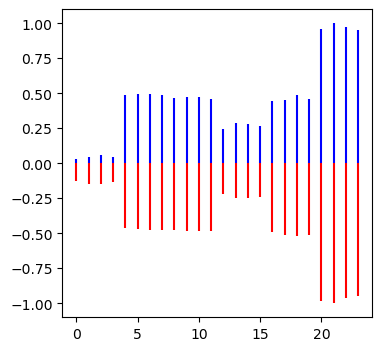

In [418]:
head_to_tail_plot(entropy_matrix[-1], entropy_matrix[0]) # SYNGAP1_T1_C1_03212024, ADNP_T2_10262023